In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.integrate import solve_ivp
from matplotlib import colors
import pickle
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import HD_utils.circular_stats as cstat
from HD_utils.network import *
from HD_utils.matrix import *
from HD_utils.adap_sim_move import *
from HD_utils.adap_sim_stable import *
from HD_utils.IO import *
from HD_utils.plot import *
from HD_utils.comput_property import *

# Parameters Set Up

In [2]:
# Simulation theta precision
theta_num = 50
dtheta = (2*np.pi)/theta_num
theta_range = np.arange(-np.pi+dtheta/2, np.pi, dtheta) # must use np.arange(-np.pi+dtheta/2, np.pi, dtheta) to make it symmetry
# Changeable parameters
ring_num = 1
actfun = max0x
weight_fun = asym_vw_wde_general
search_pars = {'JI': np.linspace(-100,0,26), 'JE': np.linspace(0,100,26)}
file_pre_name = '65_1'
b0 = 1
b = steady_inputb_withb0(b0, 0, theta_num)[:theta_num] # no external input, and because this function is initially designed for 2 ring, only select the first half for one ring purpose
# Default parameters
inputs = np.array([-1, -0.6, -0.3, -0.1, 0, 0.1, 0.3, 0.6, 1])
net_diff_equa = net_diff_equa_f_in
tau = 20 # ms
# Fixed parameters
par_num = len(search_pars)
par_names = list(search_pars.keys())
search_num = len(ParameterGrid(search_pars))
zeroid = np.where(inputs == 0)[0][0]

# Load Data

In [4]:
# Load data after running the current notebook once

# network_evals, network_evaldes, network_acvs, network_pars, network_ts = load_pickle(
#     ['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)
# valid_index_s = np.where(network_evals == 'valid')[0]
# valids_num = len(valid_index_s)

# Vels, network_eval_moving, network_eval_moving_des, network_acvs_moving, network_ts_moving, network_eval_moving_sum = load_pickle(
#     ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], weight_fun, actfun, file_pre_name)

# Stable

In [5]:
# ---- Need Change
t_max1 = tau * 10 # value must be bigger than 200, if t > t_max1 & network has a bad shape, end simulation
t_max2 = tau * 50 # if t > t_max2, stop simulation, even though network has a good shape
# Routine
network_acvs = np.zeros(search_num, dtype='object')
network_evals= np.ones(search_num, dtype='U30')
network_evaldes = np.zeros(search_num, dtype='object')
network_pars = np.zeros((search_num, par_num))
network_ts = np.zeros(search_num, dtype='object')

b = steady_inputb_withb0(b0, 0, theta_num)[:theta_num]

for i, pars in enumerate(tqdm(  list(ParameterGrid(search_pars))  )):
    # --- Need change
    par_list = [pars[par_names[j]] for j in range(par_num)]
    w = weight_fun(*par_list, theta_range, 0)
    ## Routine
    s0 = net_ini(theta_num, theta_range)[:theta_num]
    y, t, network_evals[i], network_evaldes[i] = \
        inte_check_sta(net_diff_equa, t_max1, t_max2, s0, w, tau, b, theta_num, actfun)
    # Store values
    network_pars[i] = par_list
    network_acvs[i] = y
    network_ts[i] = t
# save simulation result
store_pickle([network_evals, network_evaldes, network_acvs, network_pars, network_ts], 
['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)

valid_index_s = np.where(network_evals == 'valid')[0]
valids_num = len(valid_index_s)
print(valids_num)

100%|██████████| 676/676 [00:15<00:00, 43.28it/s]

366


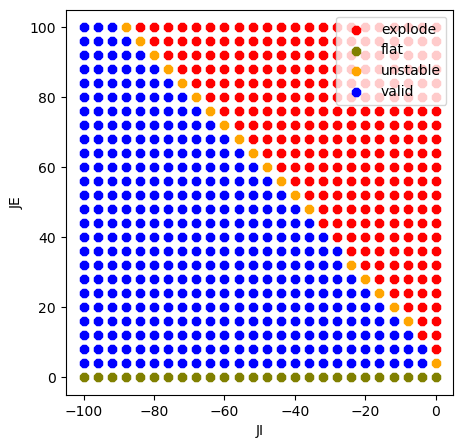

In [6]:
plot_2_par_on_type(network_evals, network_pars)

# Moving

In [7]:
# Initialize store variables
network_eval_moving = np.zeros(( search_num, len(inputs) ), dtype='U30')
network_eval_moving_sum = np.copy(network_evals)
network_vvcor = np.zeros((search_num, ring_num, 2))
network_acvs_moving = np.zeros((search_num, len(inputs)), dtype='object')
network_ts_moving = np.zeros((search_num, len(inputs)), dtype='object')
Vels = np.zeros((search_num, len(inputs), ring_num)) 

for i in tqdm(valid_index_s):
    # Routine
    s1 = network_acvs[i][:,-1] # Initial state is the stable state in the stationary case
    for ratioi, ratiov in enumerate(inputs):
        w = weight_fun(*network_pars[i], theta_range, ratiov) # ---- Need Change
        ## Compute network dynamics 
        y, t, network_eval_moving[i,ratioi], Vels[i,ratioi] = inte_check_move(
            net_diff_equa, s1, w, tau, b, theta_num, actfun)
        ## Store values
        network_acvs_moving[i,ratioi] = y
        network_ts_moving[i,ratioi] = t
    ## Examine
    network_eval_moving[i][zeroid] = 'stable moving'
    network_eval_moving_sum[i] = 'valid stationary shape'
    if np.all(network_eval_moving[i] == 'stable moving'):
        network_vvcor[i] = cal_correlation(inputs, Vels[i])
        network_eval_moving_sum[i] = exam_vv_linearity(network_vvcor[i])
## save simulation result
store_pickle([Vels, network_eval_moving, network_vvcor, network_acvs_moving, network_ts_moving, network_eval_moving_sum], 
             ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], 
             weight_fun, actfun, file_pre_name)

100%|██████████| 366/366 [00:55<00:00,  6.63it/s]


In [8]:
valid_index_stable_move = np.where(np.isin(network_eval_moving_sum, ('linear moving', 'mid-linear moving', 'nonlinear moving')))[0]

linear_move_bol = network_eval_moving_sum == 'linear moving'
valid_index_linear_move = np.where(linear_move_bol)[0]

mid_linear_move_bol = network_eval_moving_sum == 'mid-linear moving'
valid_index_mid_linear_move = np.where(mid_linear_move_bol)[0]

print('Stable still, Stable moving, Half Linear, Whole Linear')
print(len(valid_index_s), len(valid_index_stable_move), len(valid_index_mid_linear_move), len(valid_index_linear_move))

Stable still, Stable moving, Half Linear, Whole Linear
366 366 0 366


# Examination

In [9]:
height_m_w = np.zeros((search_num, len(inputs)))
height_change = np.zeros((search_num))
for i in valid_index_stable_move:
    for j in range(len(inputs)):
        height_m_w[i,j] = network_acvs_moving[i,j][:,-1].max()
    height_change[i] = height_m_w[i,-1] - height_m_w[i,0]

bottom_acv_m_w = np.zeros((search_num, len(inputs)))
bottom_acv_change = np.zeros((search_num))
for i in valid_index_stable_move:
    for j in range(len(inputs)):
        bottom_acv_m_w[i,j] = network_acvs_moving[i,j][:,-1].min()
    bottom_acv_change[i] = bottom_acv_m_w[i,-1] - bottom_acv_m_w[i,0]

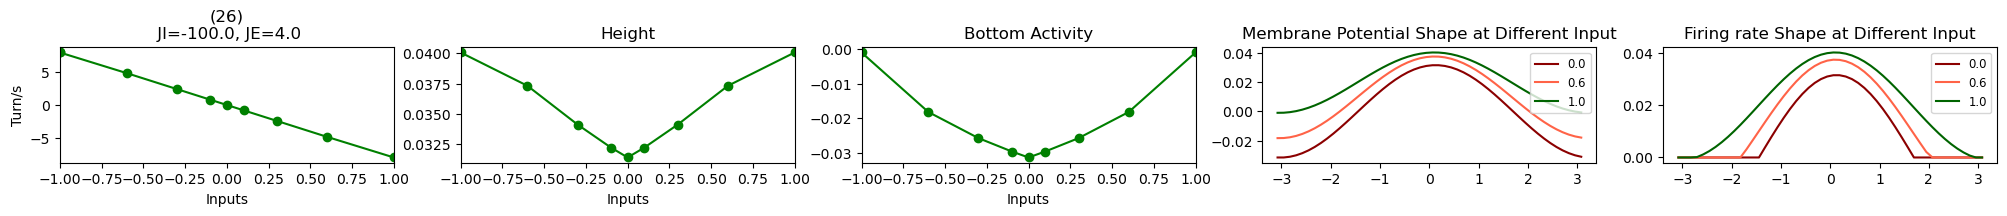

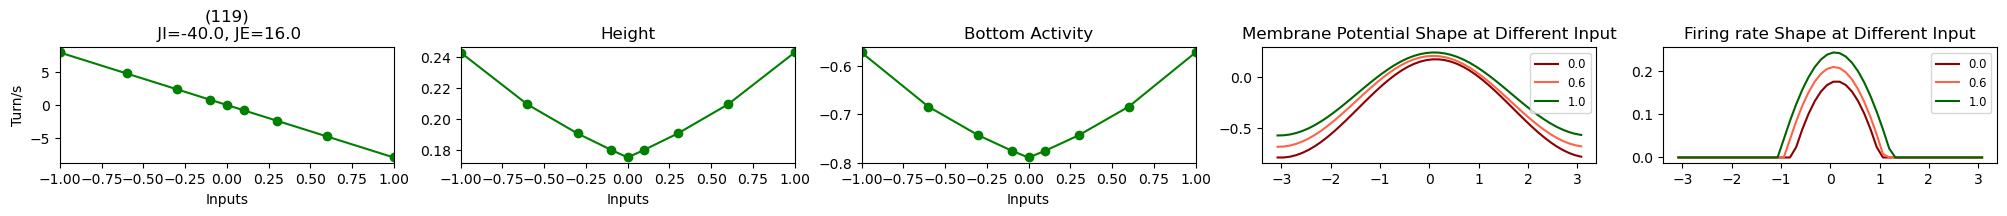

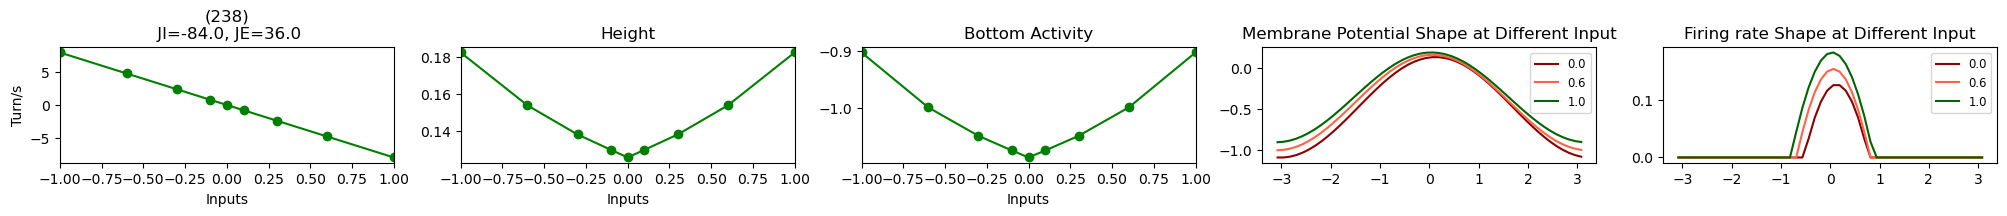

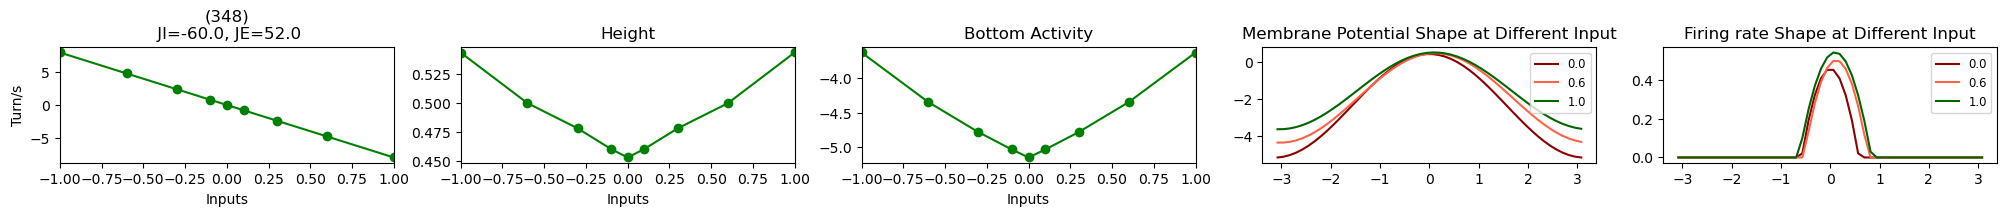

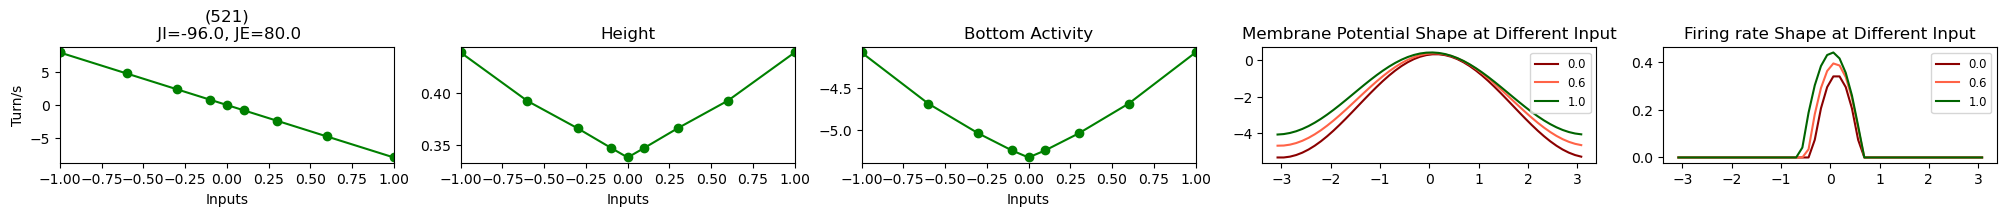

In [ ]:
index_vis = np.where(height_change > 0)[0][::47][:8]
plot_overview_25_s1ring(inputs, index_vis, network_acvs_moving, network_pars, network_eval_moving, Vels, height_m_w,
                            bottom_acv_m_w, theta_range, b0, figsize=(25,1.5), compare_ids = [zeroid, -2, -1], actfun=actfun)